This is expanded and updated version of a [much older post](https://rdkit.blogspot.com/2014/08/picking-diverse-compounds-from-large.html).

This post explores two different approaches for picking diverse small subsets of compounds from large sets: random selection and the MaxMin algorithm (Ashton, M. et. al., Quant. Struct.-Act. Relat., 21 (2002), 598-604).

The TL;DR is that if you want to pick a small number of compounds from a large set, the fastest way (by far) to do so is to just randomly select compounds.

In [1]:
import numpy as np

from rdkit import Chem
from rdkit.Chem import Draw,rdMolProcessing,rdFingerprintGenerator
from rdkit.Chem.Draw import IPythonConsole
from rdkit import SimDivFilters,DataStructs

import gzip
from matplotlib import pyplot as plt
%matplotlib inline

from rdkit import rdBase

import rdkit
print(rdkit.__version__)
import time
print(time.asctime())

2025.03.3
Thu Jul 10 06:21:44 2025


Start by getting a copy of the ChEMBL35 SDF using the [`chembl_downloader`](https://github.com/cthoyt/chembl-downloader).

In [2]:
import chembl_downloader
sdName = chembl_downloader.download_sdf(version='35')
print(sdName)

/home/glandrum/.data/chembl/35/chembl_35.sdf.gz


Efficiently generate the fingerprints using the [`rdMolProcessing`](http://localhost:8888/notebooks/2024_New_Stuff.ipynb#rdMolProcessing) package:

In [3]:
import time

fpg = rdFingerprintGenerator.GetMorganGenerator(radius=2,fpSize=1024)

opts = rdMolProcessing.SupplierOptions()
opts.numThreads = 8

with rdBase.BlockLogs():
    t1 = time.time() 
    fps = rdMolProcessing.GetFingerprintsForMolsInFile(sdName,options=opts,generator=fpg)
    t2=time.time()
fps = [x for x in fps if x is not None]
print(f'{t2-t1:.2f}s, {len(fps)} fingerprints.')

60.71s, 2474577 fingerprints.


Now do a standard diversity pick of 1000 compounds using the RDKit's MaxMinPicker and Roger Sayle's [lazy bit vector picker](https://github.com/rdkit/UGM_2017/blob/master/Presentations/Sayle_RDKitDiversity_Berlin17.pdf):

In [9]:
import time
mmp =SimDivFilters.MaxMinPicker()
t1=time.time()
bv_ids = mmp.LazyBitVectorPick(fps,len(fps),1000)
t2=time.time()
print("That took %.3f seconds"%(t2-t1))

That took 13.514 seconds


Assess the diversity by looking at a histogram of similarities between the picked compounds:

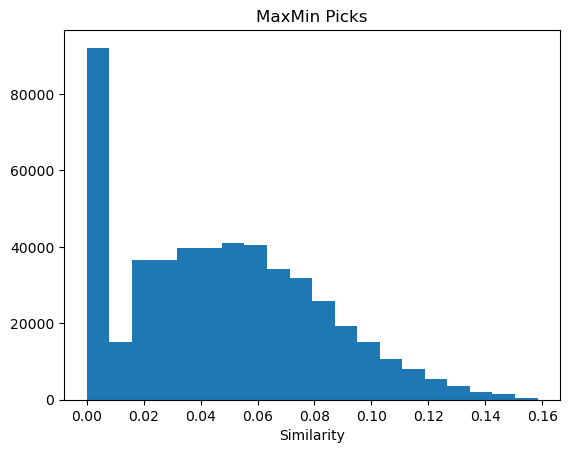

In [10]:
dist_hist=[]
for i in range(len(bv_ids)):
    for j in range(i+1,len(bv_ids)):
        dist_hist.append(DataStructs.TanimotoSimilarity(fps[bv_ids[i]],fps[bv_ids[j]]))

plt.hist(dist_hist,bins=20)
plt.title("MaxMin Picks")
plt.xlabel("Similarity");

That definitely yields compounds that have a low similarity to each other.

An alternative, and much faster, method for picking small diverse subsets from a large set is to simply randomly pick. Let's see how that does here:

In [16]:
import random
random.seed(0xa100f)
rr = list(range(len(fps)))
random.shuffle(rr)
# this is our random pick, it takes no time at all
r_ids = rr[:1000]



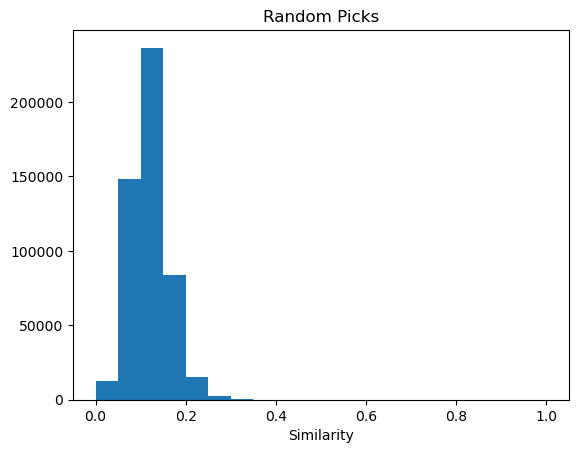

In [23]:
rfps = [fps[i] for i in r_ids]
dist_hist2=[]
for i in range(len(rfps)):
    dist_hist2.extend(DataStructs.BulkTanimotoSimilarity(rfps[i],rfps[i+1:]))
plt.hist(dist_hist2,bins=20)
plt.title("Random Picks")
plt.xlabel("Similarity");

At first glance, it looks like the random picks are much less diverse than the picks with the MaxMin algorithm: the peak in the first histogram is significantly shifted to higher similarity.

However: there is an important detail to keep in mind: the "noise level" of the fingerprint. In an [earlier post] (https://greglandrum.github.io/rdkit-blog/posts/2021-05-18-fingerprint-thresholds1.html), I looked at similarities between random pairs of "drug-like" compounds from ChEMBL in order to identify thresholds for when a similarity value is at the noise level (defined by finding the value which 99% of random pairs have a lower similarity). For the fingerprint used here, Morgan2, this value is 0.226.

Using that cutoff, we can easily figure out what fraction of the pairs in the set above are "noise":

In [24]:
noise=0.226
count = sum([1 for x in dist_hist2 if x<noise])
print(f"Count: {count}, fraction: {count/len(dist_hist2)}")



Count: 492873, fraction: 0.9867327327327328


So almost 99% of the pairs are below the noise level, exactly what we would expect for random pairs based on the [similarity thresholds blog post](https://greglandrum.github.io/rdkit-blog/posts/2021-05-18-fingerprint-thresholds1.html).

If we really, really don't want any picks to have a similarity above the threshold, we can modify the random picking approach slightly to make sure we don't accidentally add a close neighbor:

In [25]:
noise = 0.226
nPicks = 1000

import random
random.seed(0xa100f)
rr = list(range(len(fps)))
random.shuffle(rr)

rfps = [fps[rr[0]]]
r_ids = [rr[0]]
which = 1
while len(r_ids) < nPicks:
    rj = rr[which]
    if np.max(DataStructs.BulkTanimotoSimilarity(fps[rj],rfps))<noise:
        r_ids.append(rj)
        rfps.append(fps[rj])
    which += 1



This takes a bit longer but gets us the desired result:

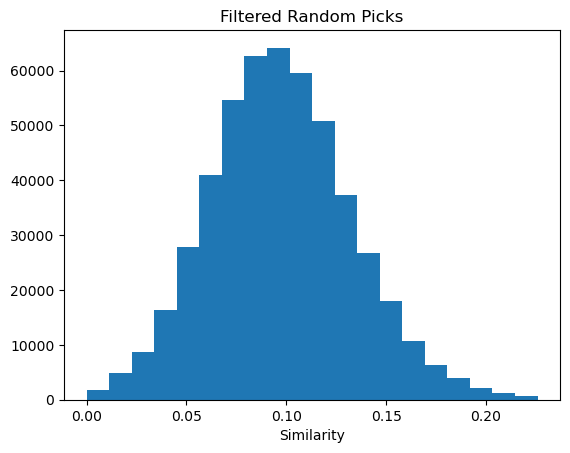

In [26]:
rfps = [fps[i] for i in r_ids]
dist_hist2=[]
for i in range(len(rfps)):
    dist_hist2.extend(DataStructs.BulkTanimotoSimilarity(rfps[i],rfps[i+1:]))
plt.hist(dist_hist2,bins=20)
plt.title("Filtered Random Picks")
plt.xlabel("Similarity");

In [27]:
noise=0.226
count = sum([1 for x in dist_hist2 if x<noise])
print(f"Count: {count}, fraction: {count/len(dist_hist2)}")



Count: 499500, fraction: 1.0


**Fazit:** randomly picking small numbers of compounds from the large set gives subsets that are quite diverse. It's also a lot quicker than using the diversity picker: not only can we skip the diversity picking algorithm, but the molecules and fingerprints don't even need to be constructed.

Clearly this is not going to work as well when picking from compounds that are reasonably closely related to each other, but for small subsets of large diverse sets, random picking is a solid approach.